In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import imageio
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# load dataset
mnist_digits = tf.keras.datasets.mnist

# U-Net

 - Originally introduyced as an image segmentation tool for detecting tumours
 - U-Net is computationally less expensive and minimises information loss, compared to predecessors

## Key Operations

### Convolutions

 - Retains the influence of all input pixels but keeps them only loosely connected to reduce computation cost
 - Passes a filter matrix K over the image
 - Consider an input matrix with dimensions (Height x Width x Depth/Channels) A x B x C
 - Consider a filter matrix with dimensions (Height, Width, Depth (same as image), Number of filters) f x f x C x G
 - We have padding p and stride s
 - The output matrix will have dimensions H x W x G
   - H = $\lfloor\frac{A+2p-f}{s}+1\rfloor$

   - G = $\lfloor\frac{B+2p-f}{s}+1\rfloor$

### Transposed Convolutions (up-conv)

 - Transposed convolutions upscale images (compared to standard convolutions which reduce resolution)
 - This is achieved by using a filter bigger than the image

### Pooling (max pool)

 - Pooling is used for the same purpose as convolution (reducing parameters)
 - Also provides regularisation
 - Average or max
 - We create subsets of the input based on filter size f and stride s

### Skip Connections (copy and crop)

 - These copy the image matrix from earlier layers and uses it as a part of the later layers
 - Enables the preservation of image from a richer matrix and prevents information loss

## Defining the Architecture

 - We use the key operations above in reuseable mini blocks

### Encoder Blocks

In [3]:
def create_encoder_block(inputs, num_of_filters, dropout_prob=0.3, use_max_pooling=True):
    conv = tf.keras.layers.Conv2D(num_of_filters,
                                    3,
                                    activation='relu',
                                    padding='same',
                                    kernel_initializer='HeNormal')(inputs)

    conv = tf.keras.layers.Conv2D(num_of_filters,
                                    3,
                                    activation='relu',
                                    padding='same',
                                    kernel_initializer='HeNormal')(conv)

    conv = tf.keras.layers.BatchNormalization()(conv, training=False)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    
    if use_max_pooling:
        next = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next = conv

    skip_conn = conv
    return next, skip_conn

In [4]:
def create_decoder_block(prev_layer_input, skip_layer_input, num_of_filters):
    up = tf.keras.layers.Conv2DTranspose(num_of_filters,
                                            (3,3),
                                            strides=(2,2),
                                            padding='same')(prev_layer_input)

    merge = tf.keras.layers.concatenate([up, skip_layer_input], axis=3)

    conv = tf.keras.layers.Conv2D(num_of_filters,
                                    3,
                                    activation='relu',
                                    padding='same',
                                    kernel_initializer='HeNormal')(merge)

    conv = tf.keras.layers.Conv2D(num_of_filters,
                                  3,
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer='HeNormal')(conv)

    return conv

In [5]:
def create_unet(input_size=(128,128,3), num_of_filters=32, num_of_classes=3):
    inputs = tf.keras.layers.Input(input_size)

    enc1 = create_encoder_block(inputs,  num_of_filters,    dropout_prob=0,   use_max_pooling=True)
    enc2 = create_encoder_block(enc1[0], num_of_filters*2,  dropout_prob=0,   use_max_pooling=True)
    enc3 = create_encoder_block(enc2[0], num_of_filters*4,  dropout_prob=0,   use_max_pooling=True)
    enc4 = create_encoder_block(enc3[0], num_of_filters*8,  dropout_prob=0.3, use_max_pooling=True)
    enc5 = create_encoder_block(enc4[0], num_of_filters*16, dropout_prob=0.3, use_max_pooling=False)

    dec6 = create_decoder_block(enc5[0], enc4[1], num_of_filters*8)
    dec7 = create_decoder_block(dec6,    enc3[1], num_of_filters*4)
    dec8 = create_decoder_block(dec7,    enc2[1], num_of_filters*2)
    dec9 = create_decoder_block(dec8,    enc1[1], num_of_filters)

    conv9 = tf.keras.layers.Conv2D(num_of_filters,
                                    3,
                                    activation='relu',
                                    padding='same',
                                    kernel_initializer='HeNormal')(dec9)

    conv10 = tf.keras.layers.Conv2D(num_of_classes,
                                    1,
                                    padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs,
                            outputs=conv10)

    return model

In [6]:
def loadData(p1, p2):
    image_dataset = os.listdir(p1)
    mask_dataset = os.listdir(p2)

    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

In [7]:
def processData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.0
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

(400, 600, 3)
(400, 600)


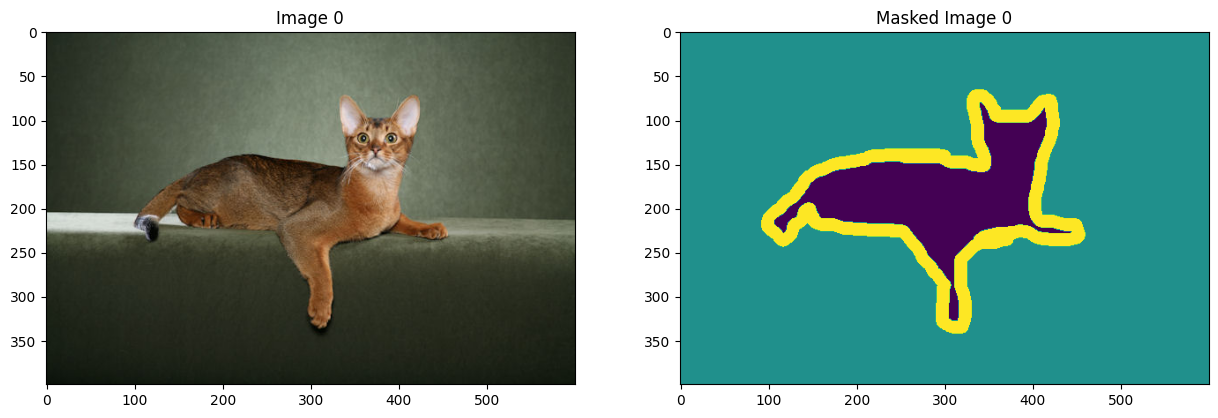

In [8]:
""" Load Train Set and view some examples """
path1 = '/Users/prana/OneDrive/Documents/University/II/DDPMs-for-Image-Inpainting/Code/OxfordPetDataset/images/'
path2 = '/Users/prana/OneDrive/Documents/University/II/DDPMs-for-Image-Inpainting/Code/OxfordPetDataset/masks/'
img, mask = loadData(path1, path2)

# View an example of image and corresponding mask 
show_images = 1
for i in range(show_images):
    img_view  = imageio.v2.imread(path1 + img[i])
    mask_view = imageio.v2.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

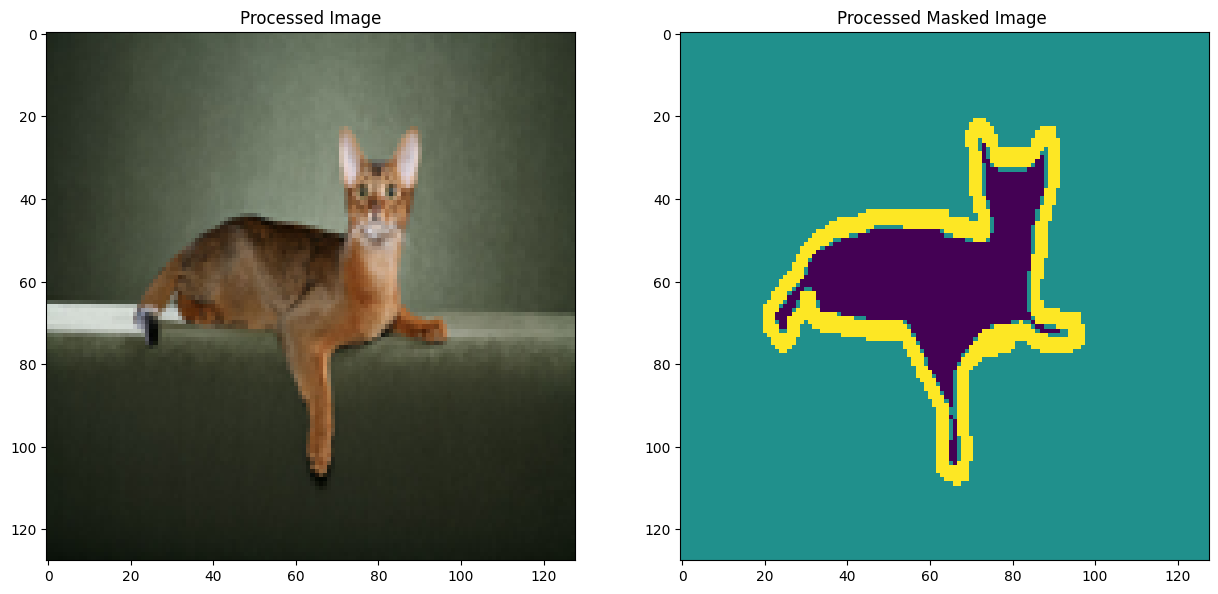

In [9]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = processData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
unet = create_unet(input_size=(128,128,3), num_of_filters=32, num_of_classes=3)

In [12]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
unet.compile(optimizer = tf.keras.optimizers.Adam(), 
             loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics   = ['accuracy'])

In [14]:
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))